Implementing AutoRec, Deep AutoEncoders for CF (improvement over AutoRec) (approved by sir)

# MODEL

In [ ]:
! pip install tensorflow

In [4]:
import gc
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils import plot_model

In [2]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [3]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     

def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     
def masked_se(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse
def masked_se_clip_10(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse     

def masked_mse(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
     

def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

def masked_mse_clip_10(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
def masked_rmse_clip_10(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

## books dataset

In [5]:
datContent = [i.strip().split() for i in open("book_ratings.dat").readlines()][1:]

In [6]:
max_user=0
max_book=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_book=max(max_book,int(r[1]))
print(max_book,max_user)

17384 2945


In [7]:
def my_proc(cont,init_val):
  matrix = np.full((max_user,max_book),init_val)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  return matrix

def my_proc_avg(cont): 
  matrix = np.full((max_user,max_book),0)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [ ]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 

In [ ]:
print(len(train_df),len(test_df),len(validate_df))

50751 6266 5639


In [ ]:
init_v = 0
users_items_matrix_train_zero = my_proc(train_df,init_v)
users_items_matrix_train_avg = my_proc_avg(train_df)
users_items_matrix_validate = my_proc(validate_df,init_v)
users_items_matrix_test = my_proc(test_df,init_v)

In [ ]:
users_items_matrix_train_zero.shape

(2945, 17384)

In [ ]:
datContent = [i.strip().split() for i in open("book_ratings.dat").readlines()][1:]

In [8]:
max_user=0
max_book=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_book=max(max_book,int(r[1]))
print(max_book,max_user)

17384 2945


In [9]:
 def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model
     

In [ ]:
Deep_AE = Deep_AE_model(users_items_matrix_train_zero,[512, 512, 1024, 512, 512], activation, last_activation, 0, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse,masked_rmse_clip_10])
Deep_AE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 17384)]           0         
                                                                 
 EncLayer0 (Dense)           (None, 512)               8901120   
                                                                 
 EncLayer1 (Dense)           (None, 512)               262656    
                                                                 
 LatentSpace (Dense)         (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 DecLayer1 (Dense)           (None, 512)               524800    
                                                                 
 DecLayer0 (Dense)           (None, 512)               262656

# Foldwise

In [11]:
import gc

In [10]:
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,shuffle=True,random_state=999613182)
folds=[] #train validate, test
for train_idx, rem_idx in kf.split(datContent):
  train=[]
  validate=[]
  test=[]
  n = len(rem_idx)//2
  valid_idx=rem_idx[0:n]
  test_idx=rem_idx[n:]
  for i in train_idx:
    train.append(datContent[i])
  for i in valid_idx:
    validate.append(datContent[i])
  for i in test_idx:
    test.append(datContent[i])
  fold=[train,validate,test]
  print(len(fold[0]),len(fold[1]),len(fold[2]))
  folds.append(fold)

50124 6266 6266
50125 6265 6266
50125 6265 6266
50125 6265 6266
50125 6265 6266


In [13]:
f=0
for fold in folds:
  f+=1
  gc.collect()
  init_v = 0
  users_items_matrix_train_zero = my_proc(fold[0],init_v)
  users_items_matrix_train_avg = my_proc_avg(fold[0])
  users_items_matrix_validate = my_proc(fold[1],init_v)
  users_items_matrix_test = my_proc(fold[2],init_v)
  layers=[256]*11
  layers[5]=512
  Deep_AE = Deep_AE_model(users_items_matrix_train_zero,layers, 'tanh', 'selu', 0.5, 0.001, 0.001)
  Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse,masked_rmse_clip_10])
  hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)
  test_result = Deep_AE.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print("Fold no: ",f,test_result)


Epoch 1/100
12/12 [==============================] - 13s 842ms/step - loss: 31.1573 - masked_rmse: 3.4807 - masked_rmse_clip_10: 3.1133 - val_loss: 14.8190 - val_masked_rmse: 1.5807 - val_masked_rmse_clip_10: 1.4957
Epoch 2/100
12/12 [==============================] - 8s 731ms/step - loss: 22.4317 - masked_rmse: 2.9030 - masked_rmse_clip_10: 2.8423 - val_loss: 10.5235 - val_masked_rmse: 1.2662 - val_masked_rmse_clip_10: 1.2371
Epoch 3/100
12/12 [==============================] - 8s 676ms/step - loss: 14.3549 - masked_rmse: 2.2135 - masked_rmse_clip_10: 2.2046 - val_loss: 7.8430 - val_masked_rmse: 1.0091 - val_masked_rmse_clip_10: 0.9813
Epoch 4/100
12/12 [==============================] - 9s 769ms/step - loss: 9.5114 - masked_rmse: 1.6702 - masked_rmse_clip_10: 1.6644 - val_loss: 6.5535 - val_masked_rmse: 0.8525 - val_masked_rmse_clip_10: 0.8214
Epoch 5/100
12/12 [==============================] - 10s 906ms/step - loss: 7.2184 - masked_rmse: 1.3390 - masked_rmse_clip_10: 1.3341 - val_l

Epoch 1/100
12/12 [==============================] - 14s 957ms/step - loss: 31.1586 - masked_rmse: 3.4806 - masked_rmse_clip_10: 3.1114 - val_loss: 15.0019 - val_masked_rmse: 1.5949 - val_masked_rmse_clip_10: 1.5105
Epoch 2/100
12/12 [==============================] - 8s 718ms/step - loss: 22.5250 - masked_rmse: 2.9117 - masked_rmse_clip_10: 2.8489 - val_loss: 10.5457 - val_masked_rmse: 1.2746 - val_masked_rmse_clip_10: 1.2481
Epoch 3/100
12/12 [==============================] - 9s 734ms/step - loss: 14.1829 - masked_rmse: 2.2073 - masked_rmse_clip_10: 2.2038 - val_loss: 7.7427 - val_masked_rmse: 1.0140 - val_masked_rmse_clip_10: 0.9881
Epoch 4/100
12/12 [==============================] - 9s 785ms/step - loss: 9.3239 - masked_rmse: 1.6674 - masked_rmse_clip_10: 1.6668 - val_loss: 6.3605 - val_masked_rmse: 0.8506 - val_masked_rmse_clip_10: 0.8221
Epoch 5/100
12/12 [==============================] - 8s 704ms/step - loss: 6.9011 - masked_rmse: 1.3239 - masked_rmse_clip_10: 1.3237 - val_lo

Epoch 1/100
12/12 [==============================] - 17s 963ms/step - loss: 31.2871 - masked_rmse: 3.4893 - masked_rmse_clip_10: 3.1113 - val_loss: 15.0032 - val_masked_rmse: 1.5809 - val_masked_rmse_clip_10: 1.4882
Epoch 2/100
12/12 [==============================] - 9s 789ms/step - loss: 22.8875 - masked_rmse: 2.9379 - masked_rmse_clip_10: 2.8678 - val_loss: 10.6833 - val_masked_rmse: 1.2700 - val_masked_rmse_clip_10: 1.2397
Epoch 3/100
12/12 [==============================] - 10s 906ms/step - loss: 14.4157 - masked_rmse: 2.2251 - masked_rmse_clip_10: 2.2196 - val_loss: 7.9491 - val_masked_rmse: 1.0173 - val_masked_rmse_clip_10: 0.9886
Epoch 4/100
12/12 [==============================] - 8s 678ms/step - loss: 9.4930 - masked_rmse: 1.6812 - masked_rmse_clip_10: 1.6787 - val_loss: 6.5738 - val_masked_rmse: 0.8583 - val_masked_rmse_clip_10: 0.8270
Epoch 5/100
12/12 [==============================] - 9s 794ms/step - loss: 7.0327 - masked_rmse: 1.3337 - masked_rmse_clip_10: 1.3315 - val_l

Epoch 1/100
12/12 [==============================] - 14s 895ms/step - loss: 31.3171 - masked_rmse: 3.4908 - masked_rmse_clip_10: 3.1126 - val_loss: 14.8231 - val_masked_rmse: 1.5758 - val_masked_rmse_clip_10: 1.4917
Epoch 2/100
12/12 [==============================] - 9s 794ms/step - loss: 22.7564 - masked_rmse: 2.9277 - masked_rmse_clip_10: 2.8625 - val_loss: 10.4003 - val_masked_rmse: 1.2528 - val_masked_rmse_clip_10: 1.2286
Epoch 3/100
12/12 [==============================] - 9s 797ms/step - loss: 14.3023 - masked_rmse: 2.2126 - masked_rmse_clip_10: 2.2086 - val_loss: 7.6411 - val_masked_rmse: 0.9870 - val_masked_rmse_clip_10: 0.9630
Epoch 4/100
12/12 [==============================] - 8s 687ms/step - loss: 9.4595 - masked_rmse: 1.6729 - masked_rmse_clip_10: 1.6711 - val_loss: 6.2834 - val_masked_rmse: 0.8195 - val_masked_rmse_clip_10: 0.7928
Epoch 5/100
12/12 [==============================] - 9s 757ms/step - loss: 7.0629 - masked_rmse: 1.3288 - masked_rmse_clip_10: 1.3270 - val_lo

Epoch 1/100
12/12 [==============================] - 14s 1s/step - loss: 31.3776 - masked_rmse: 3.4948 - masked_rmse_clip_10: 3.1119 - val_loss: 15.0859 - val_masked_rmse: 1.5952 - val_masked_rmse_clip_10: 1.5018
Epoch 2/100
12/12 [==============================] - 8s 669ms/step - loss: 23.0373 - masked_rmse: 2.9489 - masked_rmse_clip_10: 2.8756 - val_loss: 10.7030 - val_masked_rmse: 1.2776 - val_masked_rmse_clip_10: 1.2460
Epoch 3/100
12/12 [==============================] - 9s 772ms/step - loss: 14.6807 - masked_rmse: 2.2417 - masked_rmse_clip_10: 2.2302 - val_loss: 8.0668 - val_masked_rmse: 1.0178 - val_masked_rmse_clip_10: 0.9853
Epoch 4/100
12/12 [==============================] - 9s 768ms/step - loss: 9.9485 - masked_rmse: 1.7037 - masked_rmse_clip_10: 1.6928 - val_loss: 6.7155 - val_masked_rmse: 0.8465 - val_masked_rmse_clip_10: 0.8136
Epoch 5/100
12/12 [==============================] - 8s 692ms/step - loss: 7.5213 - masked_rmse: 1.3525 - masked_rmse_clip_10: 1.3451 - val_loss:

In [15]:
f=0
for fold in folds:
  f+=1
  gc.collect()
  init_v = 0
  users_items_matrix_train_zero = my_proc(fold[0],init_v)
  users_items_matrix_train_avg = my_proc_avg(fold[0])
  users_items_matrix_validate = my_proc(fold[1],init_v)
  users_items_matrix_test = my_proc(fold[2],init_v)
  layers=[512]*11
  layers[5]=1024
  Deep_AE = Deep_AE_model(users_items_matrix_train_zero,layers, 'tanh', 'selu', 0.65, 0.001, 0.001)
  Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse,masked_rmse_clip_10])
  hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)
  test_result = Deep_AE.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print("Fold no: ",f,test_result)

Epoch 1/100
12/12 [==============================] - 21s 2s/step - loss: 33.3192 - masked_rmse: 3.4072 - masked_rmse_clip_10: 3.0864 - val_loss: 15.6937 - val_masked_rmse: 1.4330 - val_masked_rmse_clip_10: 1.3820
Epoch 2/100
12/12 [==============================] - 17s 1s/step - loss: 18.6896 - masked_rmse: 2.3406 - masked_rmse_clip_10: 2.3097 - val_loss: 9.7458 - val_masked_rmse: 0.9340 - val_masked_rmse_clip_10: 0.9038
Epoch 3/100
12/12 [==============================] - 15s 1s/step - loss: 9.7907 - masked_rmse: 1.3813 - masked_rmse_clip_10: 1.3756 - val_loss: 7.6609 - val_masked_rmse: 0.7250 - val_masked_rmse_clip_10: 0.6901
Epoch 4/100
12/12 [==============================] - 16s 1s/step - loss: 6.9543 - masked_rmse: 0.9718 - masked_rmse_clip_10: 0.9647 - val_loss: 6.5572 - val_masked_rmse: 0.6416 - val_masked_rmse_clip_10: 0.6064
Epoch 5/100
12/12 [==============================] - 15s 1s/step - loss: 5.5566 - masked_rmse: 0.7778 - masked_rmse_clip_10: 0.7730 - val_loss: 5.8200 - 

Epoch 1/100
12/12 [==============================] - 28s 2s/step - loss: 33.3686 - masked_rmse: 3.4098 - masked_rmse_clip_10: 3.0854 - val_loss: 15.7507 - val_masked_rmse: 1.4380 - val_masked_rmse_clip_10: 1.3920
Epoch 2/100
12/12 [==============================] - 16s 1s/step - loss: 18.7559 - masked_rmse: 2.3364 - masked_rmse_clip_10: 2.3058 - val_loss: 10.0621 - val_masked_rmse: 0.9377 - val_masked_rmse_clip_10: 0.9040
Epoch 3/100
12/12 [==============================] - 17s 1s/step - loss: 10.3312 - masked_rmse: 1.3926 - masked_rmse_clip_10: 1.3821 - val_loss: 8.2726 - val_masked_rmse: 0.7263 - val_masked_rmse_clip_10: 0.6866
Epoch 4/100
12/12 [==============================] - 16s 1s/step - loss: 7.7610 - masked_rmse: 0.9865 - masked_rmse_clip_10: 0.9752 - val_loss: 7.4066 - val_masked_rmse: 0.6432 - val_masked_rmse_clip_10: 0.6032
Epoch 5/100
12/12 [==============================] - 15s 1s/step - loss: 6.4496 - masked_rmse: 0.7838 - masked_rmse_clip_10: 0.7768 - val_loss: 6.8002 

Epoch 1/100
12/12 [==============================] - 21s 2s/step - loss: 33.0178 - masked_rmse: 3.3878 - masked_rmse_clip_10: 3.0780 - val_loss: 15.3844 - val_masked_rmse: 1.4001 - val_masked_rmse_clip_10: 1.3577
Epoch 2/100
12/12 [==============================] - 15s 1s/step - loss: 18.1742 - masked_rmse: 2.3011 - masked_rmse_clip_10: 2.2799 - val_loss: 9.5395 - val_masked_rmse: 0.9161 - val_masked_rmse_clip_10: 0.8882
Epoch 3/100
12/12 [==============================] - 15s 1s/step - loss: 9.4271 - masked_rmse: 1.3542 - masked_rmse_clip_10: 1.3537 - val_loss: 7.3979 - val_masked_rmse: 0.7093 - val_masked_rmse_clip_10: 0.6765
Epoch 4/100
12/12 [==============================] - 15s 1s/step - loss: 6.6179 - masked_rmse: 0.9527 - masked_rmse_clip_10: 0.9511 - val_loss: 6.3144 - val_masked_rmse: 0.6305 - val_masked_rmse_clip_10: 0.5960
Epoch 5/100
12/12 [==============================] - 17s 1s/step - loss: 5.2247 - masked_rmse: 0.7600 - masked_rmse_clip_10: 0.7597 - val_loss: 5.5620 - 

Epoch 1/100
12/12 [==============================] - 28s 2s/step - loss: 33.2228 - masked_rmse: 3.3997 - masked_rmse_clip_10: 3.0817 - val_loss: 15.3599 - val_masked_rmse: 1.4021 - val_masked_rmse_clip_10: 1.3607
Epoch 2/100
12/12 [==============================] - 17s 1s/step - loss: 18.4506 - masked_rmse: 2.3173 - masked_rmse_clip_10: 2.2894 - val_loss: 9.4428 - val_masked_rmse: 0.8906 - val_masked_rmse_clip_10: 0.8647
Epoch 3/100
12/12 [==============================] - 16s 1s/step - loss: 10.0330 - masked_rmse: 1.3899 - masked_rmse_clip_10: 1.3792 - val_loss: 7.5518 - val_masked_rmse: 0.6778 - val_masked_rmse_clip_10: 0.6469
Epoch 4/100
12/12 [==============================] - 18s 2s/step - loss: 7.4234 - masked_rmse: 0.9854 - masked_rmse_clip_10: 0.9740 - val_loss: 6.8225 - val_masked_rmse: 0.6024 - val_masked_rmse_clip_10: 0.5695
Epoch 5/100
12/12 [==============================] - 17s 1s/step - loss: 6.2263 - masked_rmse: 0.7892 - masked_rmse_clip_10: 0.7810 - val_loss: 6.2995 -

Epoch 1/100
12/12 [==============================] - 22s 2s/step - loss: 33.3870 - masked_rmse: 3.4092 - masked_rmse_clip_10: 3.0840 - val_loss: 15.6590 - val_masked_rmse: 1.4240 - val_masked_rmse_clip_10: 1.3773
Epoch 2/100
12/12 [==============================] - 17s 1s/step - loss: 19.1567 - masked_rmse: 2.3686 - masked_rmse_clip_10: 2.3299 - val_loss: 10.0879 - val_masked_rmse: 0.9398 - val_masked_rmse_clip_10: 0.8999
Epoch 3/100
12/12 [==============================] - 18s 2s/step - loss: 10.5575 - masked_rmse: 1.4338 - masked_rmse_clip_10: 1.4167 - val_loss: 8.0570 - val_masked_rmse: 0.7171 - val_masked_rmse_clip_10: 0.6782
Epoch 4/100
12/12 [==============================] - 18s 2s/step - loss: 7.8197 - masked_rmse: 1.0118 - masked_rmse_clip_10: 0.9960 - val_loss: 7.2309 - val_masked_rmse: 0.6372 - val_masked_rmse_clip_10: 0.5969
Epoch 5/100
12/12 [==============================] - 17s 1s/step - loss: 6.4986 - masked_rmse: 0.8061 - masked_rmse_clip_10: 0.7946 - val_loss: 6.6284 

# Varying dropout

In [ ]:
import gc

In [ ]:
layers = [256, 512, 256]
# layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
losses=[]
val_losses=[]
rmses=[]
val_rmses=[]
dropouts=[0,0.5,0.65,0.8]
for d in dropouts:
  gc.collect()
  Deep_AE = Deep_AE_model(users_items_matrix_train_zero,[512, 512, 1024, 512, 512], activation, last_activation, d, regularizer_encode, regularizer_decode)
  Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse,masked_rmse_clip_10]) 
  hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)
  test_result = Deep_AE.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print(test_result)
  loss = hist_Deep_AE.history['loss']
  val_loss = hist_Deep_AE.history['val_loss']
  rmse = hist_Deep_AE.history['masked_rmse']
  val_rmse = hist_Deep_AE.history['val_masked_rmse']
  losses.append(loss)
  val_losses.append(val_loss)
  rmses.append(rmse)
  val_rmses.append(val_rmse)


Epoch 1/80
12/12 [==============================] - 18s 1s/step - loss: 24.8677 - masked_rmse: 2.9582 - masked_rmse_clip_10: 2.6080 - val_loss: 9.7359 - val_masked_rmse: 1.4312 - val_masked_rmse_clip_10: 1.3352
Epoch 2/80
12/12 [==============================] - 16s 1s/step - loss: 7.3434 - masked_rmse: 1.2616 - masked_rmse_clip_10: 1.2058 - val_loss: 7.8985 - val_masked_rmse: 1.1604 - val_masked_rmse_clip_10: 1.0958
Epoch 3/80
12/12 [==============================] - 14s 1s/step - loss: 5.2120 - masked_rmse: 0.8544 - masked_rmse_clip_10: 0.8366 - val_loss: 7.3897 - val_masked_rmse: 1.0789 - val_masked_rmse_clip_10: 1.0160
Epoch 4/80
12/12 [==============================] - 14s 1s/step - loss: 4.5660 - masked_rmse: 0.7099 - masked_rmse_clip_10: 0.7007 - val_loss: 7.0381 - val_masked_rmse: 1.0442 - val_masked_rmse_clip_10: 0.9833
Epoch 5/80
12/12 [==============================] - 15s 1s/step - loss: 4.2568 - masked_rmse: 0.6481 - masked_rmse_clip_10: 0.6406 - val_loss: 6.7767 - val_mas

Epoch 1/80
12/12 [==============================] - 17s 1s/step - loss: 27.3659 - masked_rmse: 3.1625 - masked_rmse_clip_10: 2.8008 - val_loss: 11.6228 - val_masked_rmse: 1.6652 - val_masked_rmse_clip_10: 1.3776
Epoch 2/80
12/12 [==============================] - 16s 1s/step - loss: 8.3911 - masked_rmse: 1.4137 - masked_rmse_clip_10: 1.3189 - val_loss: 8.2237 - val_masked_rmse: 1.2031 - val_masked_rmse_clip_10: 1.1331
Epoch 3/80
12/12 [==============================] - 14s 1s/step - loss: 5.4462 - masked_rmse: 0.8893 - masked_rmse_clip_10: 0.8674 - val_loss: 7.5251 - val_masked_rmse: 1.0843 - val_masked_rmse_clip_10: 1.0231
Epoch 4/80
12/12 [==============================] - 15s 1s/step - loss: 4.7778 - masked_rmse: 0.7345 - masked_rmse_clip_10: 0.7229 - val_loss: 7.2190 - val_masked_rmse: 1.0487 - val_masked_rmse_clip_10: 0.9866
Epoch 5/80
12/12 [==============================] - 14s 1s/step - loss: 4.4750 - masked_rmse: 0.6738 - masked_rmse_clip_10: 0.6621 - val_loss: 6.9856 - val_ma

Epoch 1/80
12/12 [==============================] - 16s 1s/step - loss: 28.1096 - masked_rmse: 3.2178 - masked_rmse_clip_10: 2.8682 - val_loss: 14.3656 - val_masked_rmse: 1.9623 - val_masked_rmse_clip_10: 1.4099
Epoch 2/80
12/12 [==============================] - 16s 1s/step - loss: 9.2189 - masked_rmse: 1.5213 - masked_rmse_clip_10: 1.3809 - val_loss: 8.4999 - val_masked_rmse: 1.2480 - val_masked_rmse_clip_10: 1.1266
Epoch 3/80
12/12 [==============================] - 16s 1s/step - loss: 5.7008 - masked_rmse: 0.9464 - masked_rmse_clip_10: 0.9136 - val_loss: 7.5508 - val_masked_rmse: 1.0866 - val_masked_rmse_clip_10: 1.0247
Epoch 4/80
12/12 [==============================] - 16s 1s/step - loss: 4.9478 - masked_rmse: 0.7717 - masked_rmse_clip_10: 0.7581 - val_loss: 7.3234 - val_masked_rmse: 1.0560 - val_masked_rmse_clip_10: 0.9950
Epoch 5/80
12/12 [==============================] - 16s 1s/step - loss: 4.6283 - masked_rmse: 0.6996 - masked_rmse_clip_10: 0.6866 - val_loss: 7.0956 - val_ma

Epoch 1/80
12/12 [==============================] - 16s 1s/step - loss: 29.2769 - masked_rmse: 3.3062 - masked_rmse_clip_10: 2.9617 - val_loss: 20.3976 - val_masked_rmse: 2.3966 - val_masked_rmse_clip_10: 1.4497
Epoch 2/80
12/12 [==============================] - 14s 1s/step - loss: 11.8472 - masked_rmse: 1.8135 - masked_rmse_clip_10: 1.5634 - val_loss: 10.5682 - val_masked_rmse: 1.5217 - val_masked_rmse_clip_10: 1.2721
Epoch 3/80
12/12 [==============================] - 14s 1s/step - loss: 6.9777 - masked_rmse: 1.1588 - masked_rmse_clip_10: 1.0768 - val_loss: 8.3032 - val_masked_rmse: 1.1989 - val_masked_rmse_clip_10: 1.1013
Epoch 4/80
12/12 [==============================] - 16s 1s/step - loss: 5.5370 - masked_rmse: 0.8837 - masked_rmse_clip_10: 0.8520 - val_loss: 7.7253 - val_masked_rmse: 1.0972 - val_masked_rmse_clip_10: 1.0252
Epoch 5/80
12/12 [==============================] - 14s 1s/step - loss: 4.9748 - masked_rmse: 0.7539 - masked_rmse_clip_10: 0.7330 - val_loss: 7.4413 - val_

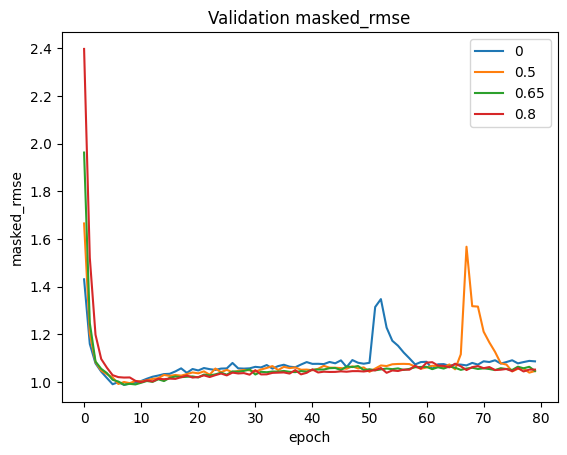

In [ ]:
for loss in val_rmses:
  plt.plot(np.arange(0, len(loss), 1), loss)

plt.title('Validation masked_rmse')
plt.ylabel('masked_rmse')
plt.xlabel('epoch')
plt.legend(['0', '0.5','0.65','0.8'], loc='best')
plt.show()

In [ ]:
len(losses)

4

In [ ]:
len(losses[0])

80

## Vary number of layers

In [ ]:
[4]*4

[4, 4, 4, 4]

In [ ]:
losses=[]
val_losses=[]
rmses=[]
val_rmses=[]
depths=[2,4,6,8,10,12]
for d in depths:
  gc.collect()
  Deep_AE = Deep_AE_model(users_items_matrix_train_zero,[128]*d, activation, last_activation,0, regularizer_encode, regularizer_decode)
  Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse,masked_rmse_clip_10]) 
  hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)
  test_result = Deep_AE.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print(test_result)
  loss = hist_Deep_AE.history['loss']
  val_loss = hist_Deep_AE.history['val_loss']
  rmse = hist_Deep_AE.history['masked_rmse']
  val_rmse = hist_Deep_AE.history['val_masked_rmse']
  losses.append(loss)
  val_losses.append(val_loss)
  rmses.append(rmse)
  val_rmses.append(val_rmse)

Epoch 1/100
12/12 [==============================] - 8s 540ms/step - loss: 29.0600 - masked_rmse: 3.5255 - masked_rmse_clip_10: 3.1125 - val_loss: 25.9969 - val_masked_rmse: 3.2064 - val_masked_rmse_clip_10: 2.8858
Epoch 2/100
12/12 [==============================] - 4s 380ms/step - loss: 22.6264 - masked_rmse: 3.0932 - masked_rmse_clip_10: 2.9612 - val_loss: 14.9650 - val_masked_rmse: 2.3594 - val_masked_rmse_clip_10: 2.2970
Epoch 3/100
12/12 [==============================] - 6s 484ms/step - loss: 9.5045 - masked_rmse: 1.8617 - masked_rmse_clip_10: 1.7389 - val_loss: 7.9523 - val_masked_rmse: 1.5243 - val_masked_rmse_clip_10: 1.2860
Epoch 4/100
12/12 [==============================] - 4s 373ms/step - loss: 4.1786 - masked_rmse: 1.1479 - masked_rmse_clip_10: 1.0259 - val_loss: 5.7848 - val_masked_rmse: 1.2766 - val_masked_rmse_clip_10: 1.2030
Epoch 5/100
12/12 [==============================] - 7s 656ms/step - loss: 2.4233 - masked_rmse: 0.8282 - masked_rmse_clip_10: 0.8136 - val_loss

Epoch 1/100
12/12 [==============================] - 8s 560ms/step - loss: 28.9960 - masked_rmse: 3.5054 - masked_rmse_clip_10: 3.1121 - val_loss: 24.5203 - val_masked_rmse: 3.0926 - val_masked_rmse_clip_10: 2.8711
Epoch 2/100
12/12 [==============================] - 6s 517ms/step - loss: 16.8069 - masked_rmse: 2.5783 - masked_rmse_clip_10: 2.5004 - val_loss: 9.1067 - val_masked_rmse: 1.6722 - val_masked_rmse_clip_10: 1.3472
Epoch 3/100
12/12 [==============================] - 6s 479ms/step - loss: 5.3455 - masked_rmse: 1.2967 - masked_rmse_clip_10: 1.0926 - val_loss: 5.9589 - val_masked_rmse: 1.3055 - val_masked_rmse_clip_10: 1.2494
Epoch 4/100
12/12 [==============================] - 7s 560ms/step - loss: 2.8128 - masked_rmse: 0.9099 - masked_rmse_clip_10: 0.8942 - val_loss: 5.0426 - val_masked_rmse: 1.1188 - val_masked_rmse_clip_10: 1.0264
Epoch 5/100
12/12 [==============================] - 6s 485ms/step - loss: 1.9895 - masked_rmse: 0.6915 - masked_rmse_clip_10: 0.6717 - val_loss:

Epoch 1/100
12/12 [==============================] - 8s 559ms/step - loss: 29.0586 - masked_rmse: 3.4931 - masked_rmse_clip_10: 3.1098 - val_loss: 23.2440 - val_masked_rmse: 2.9876 - val_masked_rmse_clip_10: 2.8212
Epoch 2/100
12/12 [==============================] - 6s 490ms/step - loss: 14.1373 - masked_rmse: 2.3169 - masked_rmse_clip_10: 2.1540 - val_loss: 7.8718 - val_masked_rmse: 1.5279 - val_masked_rmse_clip_10: 1.1960
Epoch 3/100
12/12 [==============================] - 4s 385ms/step - loss: 4.0204 - masked_rmse: 1.1084 - masked_rmse_clip_10: 1.0484 - val_loss: 5.4662 - val_masked_rmse: 1.1785 - val_masked_rmse_clip_10: 1.1176
Epoch 4/100
12/12 [==============================] - 6s 482ms/step - loss: 2.6405 - masked_rmse: 0.8227 - masked_rmse_clip_10: 0.7897 - val_loss: 4.8552 - val_masked_rmse: 1.0593 - val_masked_rmse_clip_10: 1.0013
Epoch 5/100
12/12 [==============================] - 6s 545ms/step - loss: 2.1441 - masked_rmse: 0.6831 - masked_rmse_clip_10: 0.6805 - val_loss:

Epoch 1/100
12/12 [==============================] - 8s 560ms/step - loss: 29.1448 - masked_rmse: 3.4816 - masked_rmse_clip_10: 3.1068 - val_loss: 22.2669 - val_masked_rmse: 2.8986 - val_masked_rmse_clip_10: 2.7584
Epoch 2/100
12/12 [==============================] - 7s 586ms/step - loss: 12.6172 - masked_rmse: 2.1445 - masked_rmse_clip_10: 1.9401 - val_loss: 6.3397 - val_masked_rmse: 1.2667 - val_masked_rmse_clip_10: 1.1866
Epoch 3/100
12/12 [==============================] - 6s 491ms/step - loss: 3.7974 - masked_rmse: 1.0274 - masked_rmse_clip_10: 1.0127 - val_loss: 5.7125 - val_masked_rmse: 1.1734 - val_masked_rmse_clip_10: 1.0616
Epoch 4/100
12/12 [==============================] - 6s 495ms/step - loss: 2.7746 - masked_rmse: 0.7957 - masked_rmse_clip_10: 0.7685 - val_loss: 5.1149 - val_masked_rmse: 1.0630 - val_masked_rmse_clip_10: 1.0048
Epoch 5/100
12/12 [==============================] - 5s 388ms/step - loss: 2.3747 - masked_rmse: 0.6844 - masked_rmse_clip_10: 0.6795 - val_loss:

Epoch 1/100
12/12 [==============================] - 9s 565ms/step - loss: 29.7166 - masked_rmse: 3.5027 - masked_rmse_clip_10: 3.1109 - val_loss: 24.2823 - val_masked_rmse: 3.0236 - val_masked_rmse_clip_10: 2.8331
Epoch 2/100
12/12 [==============================] - 6s 505ms/step - loss: 14.2986 - masked_rmse: 2.2727 - masked_rmse_clip_10: 2.0529 - val_loss: 6.7526 - val_masked_rmse: 1.2916 - val_masked_rmse_clip_10: 1.2235
Epoch 3/100
12/12 [==============================] - 5s 390ms/step - loss: 4.4187 - masked_rmse: 1.0986 - masked_rmse_clip_10: 1.0682 - val_loss: 5.9862 - val_masked_rmse: 1.1821 - val_masked_rmse_clip_10: 1.0612
Epoch 4/100
12/12 [==============================] - 5s 425ms/step - loss: 3.0635 - masked_rmse: 0.8080 - masked_rmse_clip_10: 0.7849 - val_loss: 5.3976 - val_masked_rmse: 1.0684 - val_masked_rmse_clip_10: 1.0055
Epoch 5/100
12/12 [==============================] - 6s 537ms/step - loss: 2.6975 - masked_rmse: 0.7006 - masked_rmse_clip_10: 0.6930 - val_loss:

Epoch 1/100
12/12 [==============================] - 9s 597ms/step - loss: 29.1320 - masked_rmse: 3.4465 - masked_rmse_clip_10: 3.0958 - val_loss: 20.1831 - val_masked_rmse: 2.6996 - val_masked_rmse_clip_10: 2.5870
Epoch 2/100
12/12 [==============================] - 6s 500ms/step - loss: 10.7151 - masked_rmse: 1.8927 - masked_rmse_clip_10: 1.6939 - val_loss: 7.1823 - val_masked_rmse: 1.3377 - val_masked_rmse_clip_10: 1.2771
Epoch 3/100
12/12 [==============================] - 6s 484ms/step - loss: 4.3777 - masked_rmse: 1.0422 - masked_rmse_clip_10: 1.0027 - val_loss: 6.0067 - val_masked_rmse: 1.1374 - val_masked_rmse_clip_10: 1.0423
Epoch 4/100
12/12 [==============================] - 5s 396ms/step - loss: 3.2246 - masked_rmse: 0.7781 - masked_rmse_clip_10: 0.7621 - val_loss: 5.6863 - val_masked_rmse: 1.0720 - val_masked_rmse_clip_10: 1.0064
Epoch 5/100
12/12 [==============================] - 6s 486ms/step - loss: 2.8688 - masked_rmse: 0.6870 - masked_rmse_clip_10: 0.6809 - val_loss:

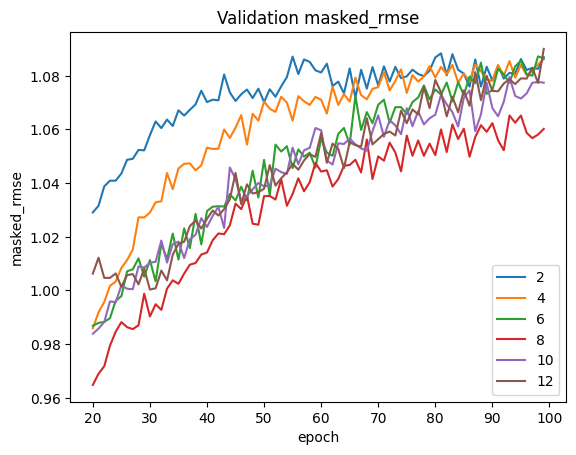

In [ ]:
for loss in val_rmses:
  plt.plot(np.arange(20, len(loss), 1), loss[20:])

plt.title('Validation masked_rmse')
plt.ylabel('masked_rmse')
plt.xlabel('epoch')
plt.legend(['2','4','6','8','10','12'], loc='best')
plt.show()

## Layer width

In [ ]:
losses=[]
val_losses=[]
rmses=[]
val_rmses=[]
width=[128,256,512,1024]
for w in width:
  gc.collect()
  Deep_AE = Deep_AE_model(users_items_matrix_train_zero,[w], activation, last_activation,0, regularizer_encode, regularizer_decode)
  Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse,masked_rmse_clip_10]) 
  hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)
  test_result = Deep_AE.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print(test_result)
  loss = hist_Deep_AE.history['loss']
  val_loss = hist_Deep_AE.history['val_loss']
  rmse = hist_Deep_AE.history['masked_rmse']
  val_rmse = hist_Deep_AE.history['val_masked_rmse']
  losses.append(loss)
  val_losses.append(val_loss)
  rmses.append(rmse)
  val_rmses.append(val_rmse)

Epoch 1/100
12/12 [==============================] - 10s 620ms/step - loss: 29.0373 - masked_rmse: 3.5319 - masked_rmse_clip_10: 3.1125 - val_loss: 26.5248 - val_masked_rmse: 3.2479 - val_masked_rmse_clip_10: 2.8865
Epoch 2/100
12/12 [==============================] - 5s 413ms/step - loss: 25.3410 - masked_rmse: 3.2978 - masked_rmse_clip_10: 3.0888 - val_loss: 22.0636 - val_masked_rmse: 2.9434 - val_masked_rmse_clip_10: 2.7920
Epoch 3/100
12/12 [==============================] - 6s 542ms/step - loss: 17.1311 - masked_rmse: 2.6659 - masked_rmse_clip_10: 2.6372 - val_loss: 14.1604 - val_masked_rmse: 2.2684 - val_masked_rmse_clip_10: 2.1901
Epoch 4/100
12/12 [==============================] - 6s 512ms/step - loss: 9.6599 - masked_rmse: 1.8809 - masked_rmse_clip_10: 1.7676 - val_loss: 10.3310 - val_masked_rmse: 1.8220 - val_masked_rmse_clip_10: 1.6705
Epoch 5/100
12/12 [==============================] - 9s 750ms/step - loss: 5.7775 - masked_rmse: 1.3808 - masked_rmse_clip_10: 1.2555 - val_

Epoch 1/100
12/12 [==============================] - 14s 1s/step - loss: 29.1736 - masked_rmse: 3.5194 - masked_rmse_clip_10: 3.1124 - val_loss: 26.2131 - val_masked_rmse: 3.2116 - val_masked_rmse_clip_10: 2.8855
Epoch 2/100
12/12 [==============================] - 8s 663ms/step - loss: 22.5262 - masked_rmse: 3.0818 - masked_rmse_clip_10: 2.9848 - val_loss: 18.8528 - val_masked_rmse: 2.6734 - val_masked_rmse_clip_10: 2.5799
Epoch 3/100
12/12 [==============================] - 8s 692ms/step - loss: 11.6393 - masked_rmse: 2.1050 - masked_rmse_clip_10: 2.0694 - val_loss: 11.3983 - val_masked_rmse: 1.9180 - val_masked_rmse_clip_10: 1.7940
Epoch 4/100
12/12 [==============================] - 7s 615ms/step - loss: 5.9960 - masked_rmse: 1.3473 - masked_rmse_clip_10: 1.1936 - val_loss: 8.8919 - val_masked_rmse: 1.6100 - val_masked_rmse_clip_10: 1.5093
Epoch 5/100
12/12 [==============================] - 8s 707ms/step - loss: 3.2303 - masked_rmse: 0.8726 - masked_rmse_clip_10: 0.8315 - val_loss

Epoch 1/100
12/12 [==============================] - 16s 1s/step - loss: 29.3469 - masked_rmse: 3.4872 - masked_rmse_clip_10: 3.1103 - val_loss: 25.0909 - val_masked_rmse: 3.1020 - val_masked_rmse_clip_10: 2.8599
Epoch 2/100
12/12 [==============================] - 18s 1s/step - loss: 17.1908 - masked_rmse: 2.6054 - masked_rmse_clip_10: 2.5767 - val_loss: 14.0431 - val_masked_rmse: 2.1724 - val_masked_rmse_clip_10: 2.0801
Epoch 3/100
12/12 [==============================] - 15s 1s/step - loss: 7.1110 - masked_rmse: 1.4493 - masked_rmse_clip_10: 1.2931 - val_loss: 9.6865 - val_masked_rmse: 1.6600 - val_masked_rmse_clip_10: 1.5639
Epoch 4/100
12/12 [==============================] - 15s 1s/step - loss: 3.3883 - masked_rmse: 0.7904 - masked_rmse_clip_10: 0.7320 - val_loss: 9.3731 - val_masked_rmse: 1.6238 - val_masked_rmse_clip_10: 1.5650
Epoch 5/100
12/12 [==============================] - 15s 1s/step - loss: 2.5185 - masked_rmse: 0.5072 - masked_rmse_clip_10: 0.4942 - val_loss: 8.8145 -

Epoch 1/100
12/12 [==============================] - 24s 2s/step - loss: 29.8079 - masked_rmse: 3.4367 - masked_rmse_clip_10: 3.0976 - val_loss: 23.8253 - val_masked_rmse: 2.9460 - val_masked_rmse_clip_10: 2.7736
Epoch 2/100
12/12 [==============================] - 23s 2s/step - loss: 11.7908 - masked_rmse: 1.9853 - masked_rmse_clip_10: 1.9406 - val_loss: 12.5482 - val_masked_rmse: 1.8861 - val_masked_rmse_clip_10: 1.7458
Epoch 3/100
12/12 [==============================] - 22s 2s/step - loss: 5.6961 - masked_rmse: 0.9858 - masked_rmse_clip_10: 0.7773 - val_loss: 12.2796 - val_masked_rmse: 1.8776 - val_masked_rmse_clip_10: 1.8184
Epoch 4/100
12/12 [==============================] - 23s 2s/step - loss: 3.6484 - masked_rmse: 0.6197 - masked_rmse_clip_10: 0.5905 - val_loss: 12.2802 - val_masked_rmse: 1.8926 - val_masked_rmse_clip_10: 1.8365
Epoch 5/100
12/12 [==============================] - 27s 2s/step - loss: 2.9141 - masked_rmse: 0.3929 - masked_rmse_clip_10: 0.3733 - val_loss: 10.928

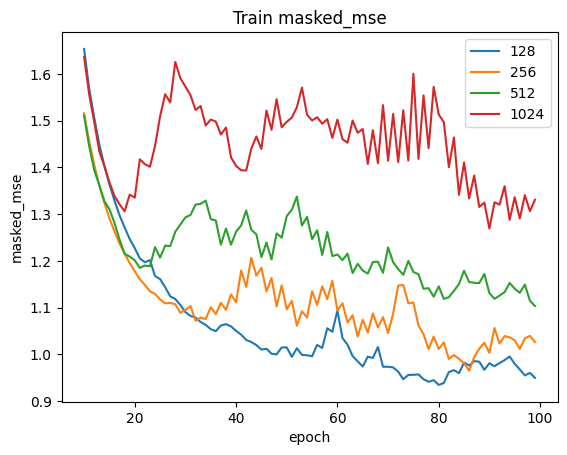

In [ ]:
for loss in losses:
  plt.plot(np.arange(10, len(loss), 1), loss[10:])

plt.title('Train masked_mse')
plt.ylabel('masked_mse')
plt.xlabel('epoch')
plt.legend(['128','256','512','1024'], loc='best')
plt.show()

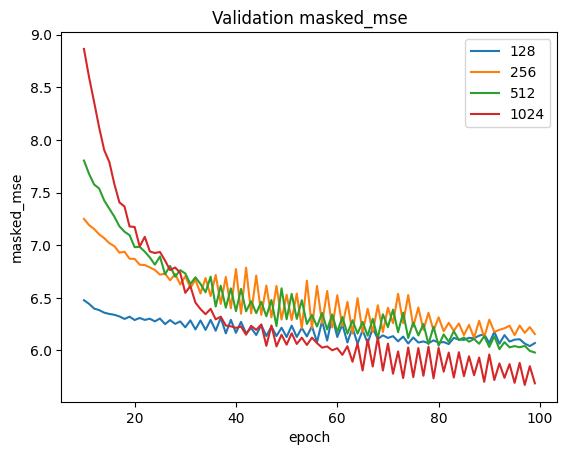

In [ ]:
for loss in val_losses:
  plt.plot(np.arange(10, len(loss), 1), loss[10:])

plt.title('Validation masked_mse')
plt.ylabel('masked_mse')
plt.xlabel('epoch')
plt.legend(['128','256','512','1024'], loc='best')
plt.show()